# In this notebook we will apply AutoRegression to do time series analysis for the weekly grosses of the Majestic Theatre

Importing necessary packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")


# Data collection

We use the weekly data from https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-04-28 for our analysis

In [2]:
#Importing the csv file that contains the data and display first 5 entries
df_raw = pd.read_csv('../DATA-COLLECTION/grosses.csv')
df_raw.head(5)

,week_ending,week_number,weekly_gross_overall,show,theatre,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
0,1985-06-09,1,3915937.0,42nd Street,St. James Theatre,282368.0,NaN,30.42,NaN,9281,1655,0.7010,8,0
1,1985-06-09,1,3915937.0,A Chorus Line,Sam S. Shubert Theatre,222584.0,NaN,27.25,NaN,8167,1472,0.6935,8,0
2,1985-06-09,1,3915937.0,Aren't We All?,Brooks Atkinson Theatre,249272.0,NaN,33.75,NaN,7386,1088,0.8486,8,0
3,1985-06-09,1,3915937.0,Arms and the Man,Circle in the Square Theatre,95688.0,NaN,20.87,NaN,4586,682,0.8405,8,0
4,1985-06-09,1,3915937.0,As Is,Lyceum Theatre,61059.0,NaN,20.78,NaN,2938,684,0.5369,8,0


In [3]:
# Define your date range
# Note: this includes both train and test data 
start_date = '2013-06-02'
end_date = '2019-05-26'

# Create a mask of the date range
mask = (df_raw['week_ending'] >= start_date) & (df_raw['week_ending'] <= end_date)

# Apply the mask to the dataframe to get only rows within your date range
df = df_raw.loc[mask]
df.head(5)


,week_ending,week_number,weekly_gross_overall,show,theatre,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
36598,2013-06-02,1,23307202.0,Ann,Vivian Beaumont Theater,195459.0,1059400.0,53.11,175.0,3680,1113,0.4133,8,0
36599,2013-06-02,1,23307202.0,Annie,Palace Theatre,800490.0,1398648.0,83.78,250.0,9555,1708,0.6993,8,0
36600,2013-06-02,1,23307202.0,Chicago,Ambassador Theatre,551330.0,1013268.0,82.09,186.0,6716,1080,0.7773,8,0
36601,2013-06-02,1,23307202.0,Cinderella,Broadway Theatre,895419.0,1613840.0,90.91,297.0,9849,1751,0.7031,8,0
36602,2013-06-02,1,23307202.0,I'll Eat You Last: A Chat With Sue Mengers,Booth Theatre,748131.0,693565.0,145.24,298.0,5151,777,0.9470,7,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9674 entries, 36598 to 46271
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   week_ending           9674 non-null   object 
 1   week_number           9674 non-null   int64  
 2   weekly_gross_overall  9674 non-null   float64
 3   show                  9674 non-null   object 
 4   theatre               9674 non-null   object 
 5   weekly_gross          9674 non-null   float64
 6   potential_gross       9674 non-null   float64
 7   avg_ticket_price      9674 non-null   float64
 8   top_ticket_price      9223 non-null   float64
 9   seats_sold            9674 non-null   int64  
 10  seats_in_theatre      9674 non-null   int64  
 11  pct_capacity          9674 non-null   float64
 12  performances          9674 non-null   int64  
 13  previews              9674 non-null   int64  
dtypes: float64(6), int64(5), object(3)
memory usage: 1.1+ MB


In [5]:
#Converting the date from string to Datetime
df['week_ending'] = pd.to_datetime(df['week_ending'])

In [6]:
#Checking that minimum value of weekly gross > 0
df.describe()

,week_number,weekly_gross_overall,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
count,9674.000000,9.674000e+03,9.674000e+03,9.674000e+03,9674.000000,9223.000000,9674.000000,9674.000000,9674.000000,9674.000000,9674.00000
mean,27.342361,2.925874e+07,9.248777e+05,1.217932e+06,107.183964,273.928928,8287.060575,1220.650093,0.864201,7.222349,0.61412
std,15.321092,6.269025e+06,5.574345e+05,4.251697e+05,48.274489,104.136986,2898.538804,338.520024,0.136650,2.271837,1.96970
min,1.000000,1.597796e+07,2.963800e+04,6.394900e+04,13.510000,167.000000,485.000000,576.000000,0.228300,0.000000,0.00000
25%,14.000000,2.511762e+07,5.447042e+05,9.454840e+05,82.060000,223.000000,6205.000000,1018.000000,0.773000,8.000000,0.00000
50%,28.000000,2.838812e+07,8.008405e+05,1.178736e+06,96.085000,248.000000,7992.000000,1080.000000,0.893900,8.000000,0.00000
75%,41.000000,3.313398e+07,1.160362e+06,1.431568e+06,121.465000,297.000000,10093.250000,1498.000000,0.985700,8.000000,0.00000
max,53.000000,5.780727e+07,4.041493e+06,3.559306e+06,511.580000,998.000000,24305.000000,1932.000000,1.058500,17.000000,8.00000


In [7]:
len(df['theatre'].unique())

43

But there are only 41 broadway theatres!!

In [8]:
np.sort(list(df['theatre'].unique()))

array(['Al Hirschfeld Theatre', 'Ambassador Theatre',
       'American Airlines Theatre', 'August Wilson Theatre',
       'Belasco Theatre', 'Bernard B. Jacobs Theatre', 'Booth Theatre',
       'Broadhurst Theatre', 'Broadway Theatre',
       'Brooks Atkinson Theatre', 'Circle in the Square Theatre',
       'Cort Theatre', 'Ethel Barrymore Theatre',
       "Eugene O'Neill Theatre", 'Foxwoods Theatre',
       'Gerald Schoenfeld Theatre', 'Gershwin Theatre',
       'Helen Hayes Theater', 'Helen Hayes Theatre', 'Hudson Theatre',
       'Imperial Theatre', 'John Golden Theatre', 'Longacre Theatre',
       'Lunt-Fontanne Theatre', 'Lyceum Theatre', 'Lyric Theatre',
       'Majestic Theatre', 'Marquis Theatre', 'Minskoff Theatre',
       'Music Box Theatre', 'Nederlander Theatre', 'Neil Simon Theatre',
       'New Amsterdam Theatre', 'Palace Theatre',
       'Richard Rodgers Theatre', 'Sam S. Shubert Theatre',
       'Samuel J. Friedman Theatre', 'St. James Theatre',
       'Stephen Sondheim

In [9]:
#Alternate spelling/names fixed
df.replace('Helen Hayes Theater', 'Helen Hayes Theatre', inplace=True)
df.replace('Foxwoods Theatre', 'Lyric Theatre', inplace=True)
df['theatre'].unique().__len__()


41

In [10]:
#Entries for each theatre in the dataset
lengths = df.groupby('theatre').size()
lengths.sort_values(ascending=False)

theatre
Minskoff Theatre                312
Ambassador Theatre              312
Gershwin Theatre                312
Eugene O'Neill Theatre          312
Majestic Theatre                312
Stephen Sondheim Theatre        307
Al Hirschfeld Theatre           305
Sam S. Shubert Theatre          293
August Wilson Theatre           286
New Amsterdam Theatre           279
Broadhurst Theatre              279
Richard Rodgers Theatre         271
Music Box Theatre               261
Bernard B. Jacobs Theatre       259
Brooks Atkinson Theatre         257
Lunt-Fontanne Theatre           248
Lyceum Theatre                  248
Ethel Barrymore Theatre         244
Broadway Theatre                235
Imperial Theatre                235
Walter Kerr Theatre             234
Circle in the Square Theatre    233
Gerald Schoenfeld Theatre       232
American Airlines Theatre       219
Winter Garden Theatre           218
Longacre Theatre                217
St. James Theatre               216
Samuel J. Friedman T

In [11]:
# Number of weeks withing this timeframe
diff = df['week_ending'].max() - df['week_ending'].min()
weeks = diff.days // 7 

print("Number of weeks between",df['week_ending'].min(), "and", df['week_ending'].max(), " = ",  weeks)

Number of weeks between 2013-06-02 00:00:00 and 2019-05-26 00:00:00  =  312


Let us choose one of the top theaters, the Majestic theater

In [12]:
#Make a new dataset for Majestic Theatre
df_majestic = df[df['theatre']=='Majestic Theatre'].reset_index()

# Data Preprocessing

## Missing Data

In [13]:
# Check for missing data
# Set week_ending as the index
df_majestic.set_index('week_ending', inplace=True)

# Resample to weekly frequency, Sunday based
resampled_df = df_majestic.resample('W-SUN').size()

# Find missing weeks
missing_weeks = resampled_df[resampled_df == 0]

print("Missing weeks:", missing_weeks)


Missing weeks: week_ending
2015-12-27    0
Freq: W-SUN, dtype: int64


### Data imputation

In [14]:
df_majestic = df_majestic.resample('W').asfreq()
df_majestic['weekly_gross'] = df_majestic['weekly_gross'].bfill()


## Duplicated data

In [15]:
# Check for duplicates
duplicate_weeks = df_majestic.index.duplicated()

print("Number of duplicate weeks: ", duplicate_weeks.sum())


Number of duplicate weeks:  0


# Data visualization

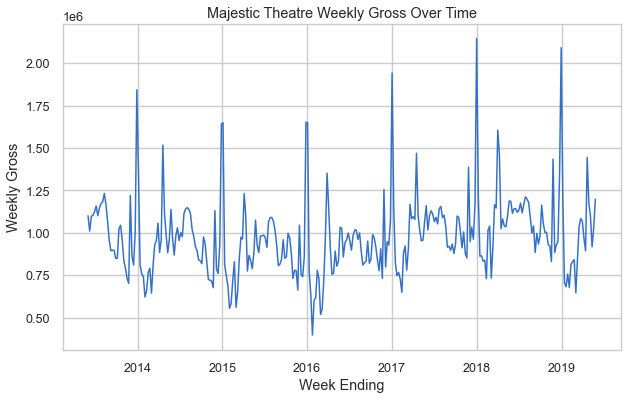

In [16]:
#Always a good idea to visualize the trends and patterns in the data.
plt.figure(figsize=(10, 6))
plt.plot(df_majestic['weekly_gross'])
plt.title('Majestic Theatre Weekly Gross Over Time')
plt.ylabel('Weekly Gross')
plt.xlabel('Week Ending')
plt.grid(True)
plt.show()


# Data Exploration
## Decompose the Time Series
Decomposing the time series into trend, seasonality, and residuals. The seasonal_decompose function can use two models - additive and multiplicative, which are different ways of combining these components to obtain the original time series. 

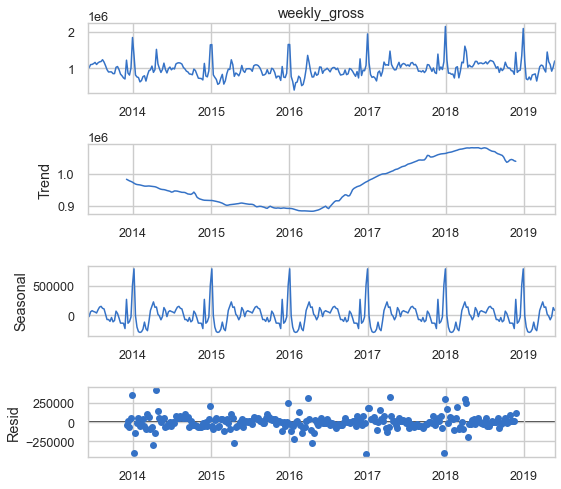

In [17]:
decomposed = seasonal_decompose(df_majestic['weekly_gross'], model='additive')
decomposed.plot()
plt.show()


Residual: The residual is what's left after the trend and seasonal components are removed from the data. It's the random variation that's left, which should ideally be white noise (i.e., random with a mean of 0) if the trend and seasonality have been fully captured. It's also where you might find unusual anomalies or outliers in your data.

# Check for Stationarity
Many time series models assume the underlying data are stationary. We will use the Augmented Dickey-Fuller test to check this. If the p-value is less than your significance level (commonly 0.05), you would reject the null hypothesis and could assume the time series is stationary.

In [18]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df['weekly_gross'])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')


ADF Statistic: -5.408765879638515
p-value: 3.2465279952305016e-06


p<0.05. Therefore, it is stationary.

# Auto Regressive model

An Autoregressive (AR) model is a representation of a random process used to describe certain time-varying processes in nature, economics, and other fields. The AR model specifies that the output variable depends linearly on its own previous values.

### The AR(p) Model
The general form of the AR(p) model (Autoregressive model of order $p$) is:

$
X_t = c + \sum_{i=1}^p \phi_i X_{t-i} + \varepsilon_t
$

where:


* $X_t$ is the time series value at time $t$.
* $c$ is a constant.
* $\phi_i$ are the parameters of the model.
* $p$ is the order of the model (i.e., the number of lags of the dependent variable included on the right side of the equation).
* $\varepsilon_t$ is white noise.

The autoregressive (AR) model predicts future behavior based on past behavior. The main idea is to predict future values based on n previous values, where n is controlled by the lags parameter. We need to find the optimal lag parameter and we iterate values up to max_lag=100

In [19]:
data = df_majestic['weekly_gross']

train_start = '2013-06-02'
train_end = '2018-05-27'
test_start = '2018-06-03'
test_end = '2019-05-26'

train_data = data[train_start:train_end] # 5 years
test_data = data[test_start:test_end]  # 1 year

In [20]:
# Choose a split point in your data
split_point = int(len(train_data) * 0.8)  # using 80% of the data for training

# Split the data into train and validation sets
train = train_data[:split_point]
valid = train_data[split_point:]

In [21]:
# Define the maximum number of lags that you want to check

max_lag = 100

# Placeholder for best parameters
best_lag = 0
best_rmse = np.inf

# Loop over possible lag parameters
for lag in range(1, max_lag+1):
  # Fit AR model
  model = AutoReg(train, lags=lag)
  model_fit = model.fit()

  # Make predictions
  predictions = model_fit.predict(
      start=len(train), end=len(train)+len(valid)-1)
  # Compute RMSE
  rmse = np.sqrt(mean_squared_error(valid, predictions))

  # Update best parameters if current RMSE is lower than best RMSE
  if rmse < best_rmse:
      best_rmse = rmse
      best_lag = lag

print(f'Best Lag: {best_lag}, Best RMSE: {best_rmse}')


Best Lag: 59, Best RMSE: 168549.0495290073


In [22]:
# Fit the model with the best lag
model = AutoReg(train_data, lags=best_lag)
model_fit = model.fit()

# Get the predictions and associated confidence intervals
predictions = model_fit.get_prediction(
    start=len(train_data), end=len(train_data) + len(test_data)-1)
pred_conf = predictions.conf_int()


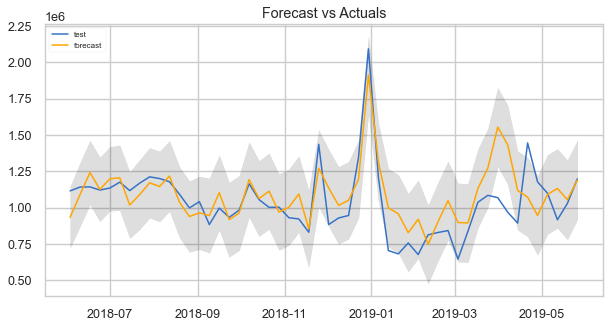

In [23]:
# Plot the data, forecast, and confidence intervals
plt.figure(figsize=(10, 5))
plt.plot(test_data.index, test_data,label='test')
plt.plot(predictions.predicted_mean.index,
         predictions.predicted_mean, color='orange', label='forecast')
plt.fill_between(pred_conf.index,
                 pred_conf.iloc[:, 0],
                 pred_conf.iloc[:, 1], color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [24]:
# Predicted values
predicted_values = predictions.predicted_mean

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, predicted_values))
print('Test RMSE: %.3f' % rmse)
# Calculate MAE
mae = mean_absolute_error(test_data, predicted_values)
print('Test MAE: %.3f' % mae)
# Calculate MAPE
mape = mean_absolute_percentage_error(test_data, predicted_values)
print('Test MAPE: %.3f' % (mape))


Test RMSE: 167139.853
Test MAE: 124601.991
Test MAPE: 0.129
